
# **CONF**

In [66]:
monk_path = 'monk/monks-'
cup_path =  'datasets/ML-CUP22-'

# **UTILS**

In [67]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import math

def load_cup_data(train=True):
    data_type = "TR" if train else "TS"
    path =cup_path+data_type+'.csv'

    columns = ["id","a1", "a2", "a3", "a4", "a5", "a6", "a7", "a8", "a9", "out1", "out2"]

    df = pd.read_csv(path,names=columns, skiprows=7)
    df = df.drop('id', axis='columns')

    return df.sample(frac=1)
 
def monk_create_df(num, train=True):
    data_type = "train" if train else "test"
    path =monk_path+str(num)+'.'+data_type

    columns = ["id", "output", "a1", "a2", "a3", "a4", "a5", "a6", "monk_id"]
    df = pd.read_csv(path, names=columns, delimiter=" ")

    df = df.drop("id", axis='columns')
    df = df.drop("monk_id", axis='columns')

    return pd.get_dummies(df, columns=df.columns[1:])

def monk_split_data_target(df):
  y = df["Class"]
  x = df.drop("Class", axis=1)
  return x.to_numpy(), y.to_numpy()

def cup_split_data_target(df):
    
    N = 2
    M = 9

    data = df.iloc[:, : M]
    target_df = df.iloc[:, -N:]

    return data, target_df


def np_monk(df, X_type=np.float, Y_type=np.int):

    matrix = df.to_numpy()

    X = matrix[:, 1:]
    X = X.astype(X_type)

    Y = matrix[:, 0]
    Y = Y.astype(Y_type)
    Y = Y.reshape(-1, 1)

    return X, Y


def np_cup_TR(df, test=False):

    matrix = df.to_numpy()
    # test samples are 20% of all the samples
    test_samples = matrix.shape[0] // 20

    # the first 80%
    dev_set = matrix[:-test_samples]
    # the last 20%
    test_set = matrix[-test_samples:]
    
    X_dev = dev_set[:, :10]
    Y_dev = dev_set[:, 9:]

    X_test = test_set[:, :10]
    Y_test = test_set[:, 10:]

    X_scaler = StandardScaler()
    X_scaler.fit(X_dev)

    if test:
        return X_scaler.transform(X_test), Y_test
    else:
        return X_scaler.transform(X_dev), Y_dev


def rescale_bin(data):
    """Rescale numpy binary array: `(0,1)` -> `(0.1,0.9)` """
    rescale = lambda x: 0.1 if x == 0 else 0.9
    v_rescale = np.vectorize(rescale)
    return v_rescale(data)

def mean_euclidian_error_loss(y_true, pred_y):
    if y_true.ndim > 1:
        l2_norms = np.linalg.norm(y_true - pred_y, axis=1)
        return np.mean(l2_norms, axis=0)
    else:
        return np.mean(np.abs(y_true - pred_y))

def MEE(y_true,y_pred,mean=True):
    assert y_pred.shape == y_true.shape, 'x and y must have same shape'
    length = y_pred.shape[0] #lunghezza RIGHE
    total = 0

    for i in range(length):
        term_one = abs( y_pred[i][0] - y_true[i][0] )
        term_two = abs( y_pred[i][1] - y_true[i][1] )

        result_in_sqrt = (term_one ** 2) + (term_two ** 2)
        result_sqrt = math.sqrt(result_in_sqrt)
        total = total + result_sqrt

    return total/length


custom_mee_scorer = make_scorer(MEE, greater_is_better=False)


def plot_NN_TR_TS(tr_stat, test_stat, name='error'):
    _, ax = plt.subplots()
    ax.plot(tr_stat, label="training")
    ax.plot(test_stat, '--', label="test")
    ax.legend()
    ax.set(xlabel='epoch', ylabel=name)
    ax.set_title(name+' per epoch')
    return ax


def plot_NN_TR_VAL(tr_stat, val_stat, name='error'):
    _, ax = plt.subplots()
    ax.plot(tr_stat, label="training")
    ax.plot(val_stat, '--', label="validation")
    ax.legend()
    ax.set(xlabel='epoch', ylabel=name)
    ax.set_title(name+' per epoch')
    return ax

/var/folders/6m/k3pmzbrs5sq0h_2x7pg04qvc0000gn/T/ipykernel_66731/3604937181.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def np_monk(df, X_type=np.float, Y_type=np.int):
/var/folders/6m/k3pmzbrs5sq0h_2x7pg04qvc0000gn/T/ipykernel_66731/3604937181.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more deta

# UTILS PLOTS RANDOM FOREST

In [68]:
import numbers

def plot_search_results(grid, title, vmin=0, vmax=3, save=True):
    # Results from grid search
    results = grid.cv_results_
    means_test = np.abs(results['mean_test_score'])
    stds_test = results['std_test_score']
    means_train = np.abs(results['mean_train_score'])
    stds_train = results['std_train_score']
    removables = ["reg__estimator__", "reg__base_estimator__", "lbe__", "reg__"]
    # Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    if len(masks_names) > 1:
        for p_k, p_v in grid.best_params_.items():
            masks.append(list(results['param_' + p_k].data == p_v))

        params = grid.param_grid

        # Ploting results
        fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(8,4))
        fig.suptitle(title)
        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i + 1:])
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            param = np.array(params[p])
            if not isinstance(params[p][0], str) and not isinstance(params[p][0], numbers.Number):
                param = np.array([str(x) for x in params[p]])
            else:
                fmt = lambda x, pos: '{:.0f}e-3'.format((x - 1) * 1e3, pos)
                if np.max(param) / np.min(param) > 10:
                    ax[i].set_xscale('log')

            mean_test = np.abs(np.array(means_test[best_index]))
            std_test = np.array(stds_test[best_index])
            mean_train = np.abs(np.array(means_train[best_index]))
            std_train = np.array(stds_train[best_index])

            ax[i].plot(param, mean_train, "--", color="b", label="Train MEE")
            ax[i].fill_between(param, mean_train + std_train, mean_train - std_train, color="b", alpha=0.2)
            ax[i].plot(param, mean_test, "-", color="g", label="Test MEE")
            ax[i].fill_between(param, mean_test + std_test, mean_test - std_test, color="g", alpha=0.2)
            ax[i].set_ylim([vmin, vmax])

            xlabel=p
            for removable in removables:
                if p.startswith(removable):
                    xlabel=p.replace(removable,"")
                    break
            ax[i].set_xlabel(xlabel)
    else:
        p = masks_names[0]
        param = grid.param_grid[p]
        fig, ax = plt.subplots(1)
        fig.suptitle(title)
        ax.set_xscale('log')
        ax.plot(param, means_train, "--", color="b", label="Train MEE")
        ax.fill_between(param, means_train + stds_train, means_train - stds_train, color="b", alpha=0.2)
        ax.plot(param, means_test, "-", color="g", label="Test MEE")
        ax.fill_between(param, means_test + stds_test, means_test - stds_test, color="g", alpha=0.2)
        xlabel = p
        for removable in removables:
            if p.startswith(removable):
                xlabel = p.replace(removable, "")
                break
        ax.set_xlabel(xlabel)
    plt.legend()
    plt.show()

# RANDOM FOREST

In [69]:
import numpy as np
from sklearn.ensemble._bagging import BaggingRegressor
from sklearn.ensemble._forest import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics._scorer import make_scorer
from sklearn.model_selection._search import GridSearchCV
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing._data import StandardScaler
from sklearn.svm._classes import SVR
from sklearn.preprocessing import OneHotEncoder

def random_forest_model_selection(X_train, Y_train, mode="regression"):
    if mode=="regression":
        print()
        print("RANDOM FOREST REGRESSION MODEL")

        n_estimators = [10, 50]
        max_depths = np.arange(14, 50)
        max_features = np.arange(1, X_train.shape[1])
       
        r_forest_gs = Pipeline([('scl', StandardScaler()),
                                ('reg', RandomForestRegressor(random_state=42))])

        tuned_parameters = {'reg__n_estimators': n_estimators,
                            'reg__max_depth': max_depths,
                            'reg__max_features': max_features,
                            }

        scorer = make_scorer(mean_euclidian_error_loss, greater_is_better=False)
        gs = GridSearchCV(estimator=r_forest_gs,
                          cv=[(slice(None), slice(None))],
                          verbose=10,
                          param_grid=tuned_parameters,
                          scoring=custom_mee_scorer,
                          return_train_score=True,
                          n_jobs=-1)

        gs.fit(X_train, Y_train)
        for param in gs.best_params_:
            print(param + ": " + str(gs.best_params_[param]))
        print("MEE: %0.2f" % abs(gs.best_score_))
    elif mode == "classifier":
        print()
        print("RANDOM FOREST CLASSIFIER MODEL")

        n_estimators = [10, 50]
        max_depths = np.arange(5, 10)
        max_features = np.arange(1, X_train.shape[1])
        r_forest_gs = RandomForestClassifier(random_state=42)

        tuned_parameters = {'n_estimators': n_estimators,
                            'max_depth': max_depths,
                            'max_features': max_features,
                            }

        gs = GridSearchCV(estimator=r_forest_gs,
                          cv=5,
                          param_grid=tuned_parameters,
                          scoring="accuracy",
                          n_jobs=-1,
                          return_train_score=True)

        gs.fit(X_train, Y_train.ravel())
        for param in gs.best_params_:
            print(param + ": " + str(gs.best_params_[param]))
        print("ACCURACY: %0.2f" % abs(gs.best_score_))
    return gs

MONK 1

RANDOM FOREST CLASSIFIER MODEL
max_depth: 6
max_features: 13
n_estimators: 10
ACCURACY: 0.82


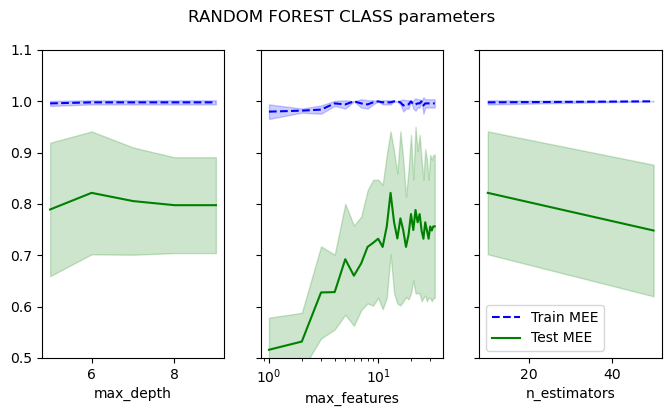

MONK 2

RANDOM FOREST CLASSIFIER MODEL
max_depth: 7
max_features: 15
n_estimators: 10
ACCURACY: 0.65


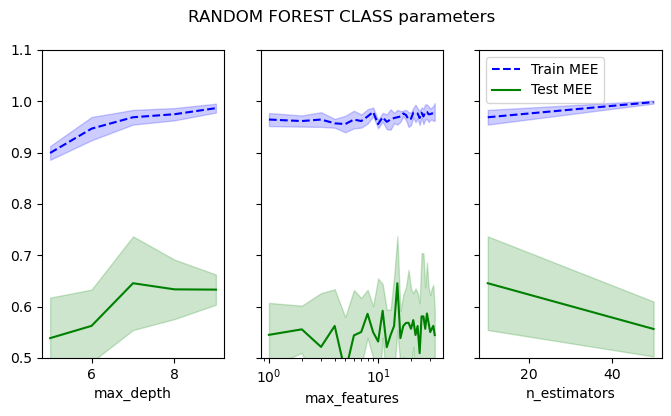

MONK 3

RANDOM FOREST CLASSIFIER MODEL
max_depth: 5
max_features: 33
n_estimators: 50
ACCURACY: 0.93


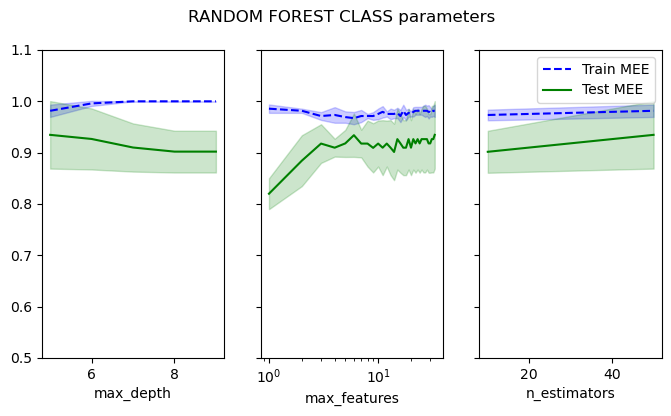

In [70]:
# RANDOM FOREST MONK
for monk_n in [1,2,3]:
  print("MONK"+" "+ str(monk_n))
  df_train = monk_create_df(monk_n)
  df_test = monk_create_df(monk_n, train=False)
  X_train, Y_train = np_monk(df_train, np.float64, np.int32)
  X_test, Y_test = np_monk(df_test, np.float64, np.int32)
  one_hot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoder.fit(X_train)
  X_train = one_hot_encoder.transform(X_train)
  X_test = one_hot_encoder.transform(X_test)
  random_forest_gs = random_forest_model_selection(X_train, Y_train, mode="classifier")
  plot_search_results(random_forest_gs, "RANDOM FOREST CLASS parameters", vmin=0.5, vmax=1.1,save=False)

# RANDOM FOREST CUP

(529, 9)

RANDOM FOREST REGRESSION MODEL
Fitting 1 folds for each of 576 candidates, totalling 576 fits
[CV 1/1; 1/576] START reg__max_depth=14, reg__max_features=1, reg__n_estimators=10
[CV 1/1; 2/576] START reg__max_depth=14, reg__max_features=1, reg__n_estimators=50
[CV 1/1; 3/576] START reg__max_depth=14, reg__max_features=2, reg__n_estimators=10
[CV 1/1; 4/576] START reg__max_depth=14, reg__max_features=2, reg__n_estimators=50
[CV 1/1; 5/576] START reg__max_depth=14, reg__max_features=3, reg__n_estimators=10
[CV 1/1; 6/576] START reg__max_depth=14, reg__max_features=3, reg__n_estimators=50
[CV 1/1; 1/576] END reg__max_depth=14, reg__max_features=1, reg__n_estimators=10;, score=(train=-0.727, test=-0.727) total time=   0.0s
[CV 1/1; 7/576] START reg__max_depth=14, reg__max_features=4, reg__n_estimators=10
[CV 1/1; 3/576] END reg__max_depth=14, reg__max_features=2, reg__n_estimators=10;, score=(train=-0.669, test=-0.669) total time=   0.0s
[CV 1/1; 8/576] START reg__max_depth=14, re

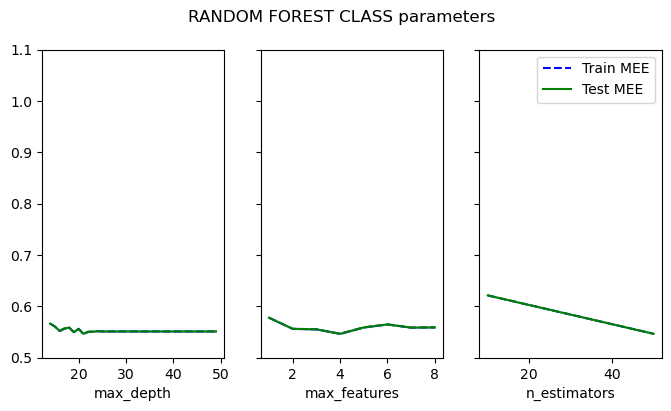

BEST MEE -0.5463775499769775


In [71]:
from sklearn.model_selection._split import train_test_split

df_train = load_cup_data(train=True)
df_test = load_cup_data(train=False)

df_test = df_test.drop('out1', axis='columns')
df_test = df_test.drop('out2', axis='columns')

X_test = df_test.to_numpy()
print(X_test.shape)

data, target = cup_split_data_target(df_train)

# Transform into numpy arrays
X_train = data.to_numpy()
Y_train = target.to_numpy()

X_train, X_inner_test, Y_train, Y_inner_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=72)


random_forest_gs = random_forest_model_selection(X_train, Y_train)
plot_search_results(random_forest_gs, "RANDOM FOREST CLASS parameters", vmin=0.5, vmax=1.1,save=False)
print("BEST MEE",random_forest_gs.best_score_)

Utility function to write the result:

In [72]:
def write_blind_results(result, file):
    # Output file in a simple text/txt format
    # The name must be: team-name_ML-CUP22-TS.csv
    # Name1 Surname1, Name2 Surname2
    # Group Name
    # data set name(ML-CUP22 v1)
    # date (e.g. 2 Jan 2022)
    df = pd.DataFrame(result)
    now = datetime.datetime.now()
    f = open(file, "w")
    f.write("# Giuliano Galloppi, Niko Paterniti Barbino, Ilaria Salogni\n")
    f.write("# GPS\n")
    f.write("# ML-CUP22 v1\n")
    f.write("# " + str(now.day) + "/" + str(now.month) + "/" + str(now.year) + "\n")
    #f.write("# 23 Jan 2023\n")
    df.index += 1
    df.to_csv(f, sep=",", encoding="utf-8", header=False)
    f.close()

#  **Model Assessment**:

Since from *model selection phase* came out that our best model is random forest. <br> Here we are going to do our testing on the internal test set.

In [73]:
Y_predict_ts = random_forest_gs.predict(X_inner_test)

mee_ts_score = MEE(Y_inner_test,Y_predict_ts)
print("MEE value on TEST SET :",mee_ts_score)

MEE value on TEST SET : 1.4725406330843451


#  **Blind Test Results**:

In [74]:
cup_path = 'datasets/ML-CUP22-'

columns = ["id", "a1", "a2", "a3", "a4", "a5", "a6","a7","a8","a9"]
df_cup_blind = pd.read_csv(cup_path+"TS.csv",comment='#', sep=',',names=columns) #10 colonne

X_blind_test = df_cup_blind.iloc[:, 0:9].values
Y_blind_pred = random_forest_gs.predict(X_blind_test)

blind_results = pd.DataFrame(Y_blind_pred,columns=["out1","out2"])

write_blind_results(blind_results,"GPS_ML-CUP22-TS.csv")